In [1]:
#--------------------------------------Approach-1 (257 pixels as input 
#------------------------------------------------and a integer(1-32) as output)-------------------------
import keras
from PIL import Image, ImageOps
import cv2
import numpy as np
import glob
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from natsort import natsorted
from keras.utils.np_utils import to_categorical
import tensorflow as tf

%matplotlib inline
np.random.seed(123)
#---------------------These values are later used for making all pixels value either 0 or 1-----------
threshold = 127.0
max_value = 255.0
#----------------------------------------------------------------
int_labels = []
for i in range(32):
    int_labels.append(i)
#-----------------------loading training set images into X_train------------------------ 
filelist_t = natsorted(glob.glob(r'/Users/apple/Desktop/dataseta2/traina2/*.jpeg'))
#    making all the values either 0 0r 1
X_train = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_t ])
X_train = (X_train > threshold) * max_value
X_train = X_train / 255.
print (X_train[0].shape)

Y_train = to_categorical(int_labels, num_classes = 32)
#Y_train = ['A','B','D','E','G','H','I','K','Q','a','b','e','g','h','i','j','m','p','s','t','u','w','x','y','z','1','2','4','5','6','8','0']
#-----------------------------------------------------------------
#----------------------loading testing set images into X_test------------------------------ 
filelist = natsorted(glob.glob(r'/Users/apple/Desktop/dataseta2/testa2/*.jpeg'))
X_test = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist ])
#    making all the values either 0 0r 1
X_test = (X_test > threshold) * max_value
X_test = X_test.astype(float) / 255.
Y_test = to_categorical(int_labels, num_classes = 32)
Y_test = np.asarray(Y_test)
#Y_test = ['C','F','J','L','M','N','O','P','R','S','T','U','V','W','X','Y','Z','c','d','f','l','n','o','q','r','v','3','7','9',':','!','"']

(16, 16)


In [2]:
#-----------------------Reshaping all the images from 16*16 to 256---------------------------
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)


Train dimension:
(32, 256)
Test dimension:
(32, 256)


In [4]:
#------------------------Initialise the model-------------------------
model = keras.models.Sequential()
model.add(keras.Input(shape=(256,)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32))
model.output_shape

(None, 32)

In [5]:
#-------------------------Collecting predictions and intialising 
#-------------------------------------------------loss function as categorical crossentropy--------------------
predictions = model(X_train[:1]).numpy()
tf.nn.softmax(predictions).numpy()
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
loss_fn(Y_train[:1], predictions).numpy()

4.1997156

In [6]:
#-------------------------model summary----------------------
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 59,744
Trainable params: 59,744
Non-trainable params: 0
_________________________________________________________________


In [7]:
#---------------------------model compiling and fitting------------------------
model.compile(optimizer='SGD',loss=loss_fn,metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=500,batch_size=16,validation_split=0.5,validation_data = X_train)

In [23]:
#---------------------------Evaluating the model------------------------------
model.evaluate(X_test, Y_train, verbose =1)
Y_pred = []
Y_pred = model.predict_classes(X_test, verbose=1)
print()
print()
print ("The predictions for given X_test:")
print (Y_pred)

1/1 [==============================] - 0s 14ms/step


The predictions for given X_test:
[ 4  3 14  3  0  2  5  3  7 14  6  5 14 11  0 14 15 11 13  6  6  9 15  5
  3 12 14  3  8 14 15  6]


In [10]:
#---------------------This function calculates ffa-----------------------------------
def calculate_ffa(input_image,output_image):
    wrong_blacks = 0.0
    whites = 0.0
    for i in range (256):
        if(input_image[i] == 0 and output_image[i]!=0):
            wrong_blacks = wrong_blacks + 1
    for j in range (256):
        if(input_image[j] == 1):
            whites = whites + 1        
    return wrong_blacks/whites
#---------------------This function calculates fh-----------------------------------
def calculate_fh(input_image,output_image):
    correct_blacks = 0.0
    blacks = 0.0
    for i in range (256):
        if(input_image[i] == 0):
            if(output_image[i] == 0):
                correct_blacks = correct_blacks + 1
    for j in range (256):
        if(input_image[j] == 0):
            blacks = blacks + 1        
    return correct_blacks/blacks    

In [11]:
#---------------------This function calculates ffa for noisy images-------------------
def calculate_noisy_ffa(input_image,output_image):
    wrong_blacks = 0.0
    whites = 0.0
    for i in range (256):
        if(input_image[i] <= 0.5 and output_image[i]>0.5): 
            # we consider that if value is less than 0.5 then its black else its white
            wrong_blacks = wrong_blacks + 1
    for j in range (256):
        if(input_image[j] > 0.5):
            whites = whites + 1        
    return wrong_blacks/whites
#---------------------This function calculates fh for noisy images-------------------
def calculate_noisy_fh(input_image,output_image):
    correct_blacks = 0.0
    blacks = 0.0
    for i in range (256):
        if(input_image[i] <= 0.5):# we consider that if value is less than 0.5 then its black else its white
            if(output_image[i] <= 0.5):
                correct_blacks = correct_blacks + 1
    for j in range (256):
        if(input_image[j] <= 0.5):
            blacks = blacks + 1        
    return correct_blacks/blacks

In [12]:
ffa_list = []
fh_list = []
k=0
for i in range(32):
    index=Y_pred[k]
    ffa_list.append(calculate_ffa(X_test[i],X_train[index]))
    fh_list.append(calculate_fh(X_test[i],X_train[index]))
    k=k+1
print("The ffa values for Noiseless image input:")
print (ffa_list)
print("The fh values for Noiseless image input:")
print (fh_list)

The ffa values for Noiseless image input:
[0.02336448598130841, 0.010101010101010102, 0.22330097087378642, 0.0, 0.15458937198067632, 0.27439024390243905, 0.21839080459770116, 0.1595744680851064, 0.13903743315508021, 0.1778846153846154, 0.08520179372197309, 0.047619047619047616, 0.12272727272727273, 0.2756756756756757, 0.13145539906103287, 0.08597285067873303, 0.14678899082568808, 0.08796296296296297, 0.16145833333333334, 0.11004784688995216, 0.04035874439461883, 0.1595744680851064, 0.2708333333333333, 0.19553072625698323, 0.09615384615384616, 0.1031390134529148, 0.23618090452261306, 0.06944444444444445, 0.1477832512315271, 0.025423728813559324, 0.0990990990990991, 0.09049773755656108]
The fh values for Noiseless image input:
[0.8809523809523809, 0.9655172413793104, 0.08, 1.0, 0.3469387755102041, 0.5108695652173914, 0.5365853658536586, 0.5588235294117647, 0.6231884057971014, 0.22916666666666666, 0.42424242424242425, 0.8656716417910447, 0.25, 0.28169014084507044, 0.3488372093023256, 0.45

Text(0.5, 1.0, 'A graph with fh on the ordinate axis and ffa on the abscissa')

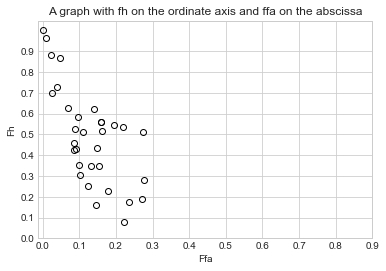

In [13]:
#----------------------The ffa vs fh graph plotting-------------
%matplotlib inline
import matplotlib.pyplot as plt


plt.style.use('seaborn-whitegrid')
plt.plot(ffa_list,fh_list,'o',color='black', markerfacecolor='none')
plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))
#-----------------Naming and labeling the graph---------------------
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('A graph with fh on the ordinate axis and ffa on the abscissa')


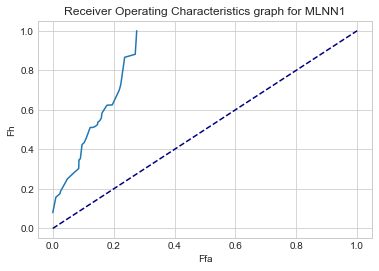

AUC: 0.1353279145728183


In [14]:
#----------------------------ROC curve for noiseless images------------------
X = sorted(ffa_list)
Y = sorted(fh_list)
plt.plot(X,Y)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver Operating Characteristics graph for MLNN1')
plt.show() 

#-----------------------------Print AUC (area under the curve)---------------
auc = np.trapz(X,Y)
print('AUC:', auc)


In [15]:
#-------------------This is the gaussian noise that will be added to the input dataset-----------------------
#----------------------This is traditional additive gaussian noise added to the image------------------------
import random
def gaussy(X_noisy,std_dev,m):   
    X_noisy_temp = np.copy(X_noisy)
    random.seed(m)
    mean=0.0
    random_index=random.sample(range(256), 25)
    #print((random_index[0]))  
    np.random.seed(m)
    gauss=np.random.normal(mean,std_dev,(25,1,1))
    gauss=gauss.reshape(25,)
    #print(gauss)
#--------------------Normalization of pixel values to be in range (0,1)-------------------------------
    for j in range(20):
        for i in range(25):
            noisy_index=random_index[i]
            X_noisy_temp[j][noisy_index]=X_noisy_temp[j][noisy_index]+gauss[i]
#
    for j in range(20):
        for i in range(256):
            X_noisy_temp[j][i] = (X_noisy_temp[j][i] - np.amin(X_noisy_temp[j]))/(np.amax(X_noisy_temp[j]) - np.amin(X_noisy_temp[j]))
     
    #print (X_noisy[0])
    return X_noisy_temp

In [16]:
#----------------Different sets of noisy inputs are generated with different 
#-------------------------------------Standard Deviation and different seed for random number generator------
X_noisy1 = np.copy(X_test)
Noisy_1 = gaussy(X_noisy1,0.001,0)
Noisy_2 = gaussy(X_noisy1,0.002,1)
Noisy_3 = gaussy(X_noisy1,0.003,2)
Noisy_4 = gaussy(X_noisy1,0.005,3)
Noisy_5 = gaussy(X_noisy1,0.01,4)
Noisy_6 = gaussy(X_noisy1,0.02,5)
Noisy_7 = gaussy(X_noisy1,0.03,6)
Noisy_8 = gaussy(X_noisy1,0.05,7)
Noisy_9 = gaussy(X_noisy1,0.1,8)

In [17]:
#-----------------Below two lists contain all the ffa and fh values of all the noisy levels 
#------------------------------------------ can be accessed by using [a:b]-------------------------
ffa_noisy_list = [] # total 288 values = 32 data  * 9 (noise levels)
fh_noisy_list = [] # total 288 values = 32 data * 9 (noise levels)
predicts1 = model.predict_classes(Noisy_1)
predicts2 = model.predict_classes(Noisy_2)
predicts3 = model.predict_classes(Noisy_3)
predicts4 = model.predict_classes(Noisy_4)
predicts5 = model.predict_classes(Noisy_5)
predicts6 = model.predict_classes(Noisy_6)
predicts7 = model.predict_classes(Noisy_7)
predicts8 = model.predict_classes(Noisy_8)
predicts9 = model.predict_classes(Noisy_9)

Predicts = [predicts1,predicts2,predicts3,predicts4,predicts5,predicts6,predicts7,predicts8,predicts9] 
Noisy_list = [Noisy_1,Noisy_2,Noisy_3,Noisy_4,Noisy_5,Noisy_6,Noisy_7,Noisy_8,Noisy_9]
#------------------------appending all ffa fh of all noise levels into
#----------------------------------------------corresponding ffa_noisy_list and fh_noisy_list---------------------
for i,j in zip(Predicts,Noisy_list):
    h=0
    for k in range(32): 
        index= i[h]
        ffa_noisy_list.append(calculate_noisy_ffa(j[k],X_train[index]))
        fh_noisy_list.append(calculate_noisy_fh(j[k],X_train[index]))
        h=h+1
print('-' * 100)
#-----------------------The below are the predictions and their respective labels
#-----------------------------------and the correct ouputd are ['A','B','C','D','E'.....,'"','!']-----------------


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


----------------------------------------------------------------------------------------------------


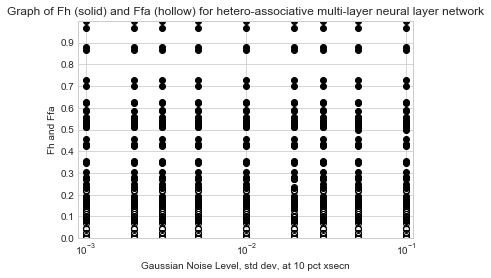

In [18]:
#----------------------The plotting of the ffa,fh vs SD is implemented below----------------------------

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

plt.style.use('seaborn-whitegrid')

#---------------------------This is for the Standard deviation 0.001-----------------------------
for i in range(0,32):
    a = i
    b = (i+1) 
    plt.plot(0.001,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.001,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.002-----------------------------
for i in range(32,64):
    a = i
    b = (i+1) 
    plt.plot(0.002,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.002,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.003-----------------------------
for i in range(64,96):
    a = i
    b = (i+1) 
    plt.plot(0.003,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.003,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.005-----------------------------
for i in range(96,128):
    a = i
    b = (i+1) 
    plt.plot(0.005,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.005,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.01-----------------------------
for i in range(128,160):
    a = i
    b = (i+1) 
    plt.plot(0.01,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.01,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.02-----------------------------
for i in range(160,192):
    a = i
    b = (i+1) 
    plt.plot(0.02,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.02,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.03-----------------------------
for i in range(192,224):
    a = i
    b = (i+1) 
    plt.plot(0.03,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.03,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.05-----------------------------
for i in range(224,256):
    a = i
    b = (i+1) 
    plt.plot(0.05,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.05,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
#---------------------------This is for the Standard deviation 0.1------------------------------
for i in range(256,288):
    a = i
    b = (i+1) 
    plt.plot(0.1,fh_noisy_list[a:b], 'o', color='black')
    plt.plot(0.1,ffa_noisy_list[a:b], 'o', color='black', markerfacecolor='none')
    
#--------------The x axis is logarithmically scaled as mentioned in the  requirements----------------    
plt.xscale('log')
plt.yticks(np.arange(0,1,0.1))
plt.xlim([0.0009,0.1101])
plt.ylim([0,1])
#--------------Naming of the graph------------------
plt.xlabel('Gaussian Noise Level, std dev, at 10 pct xsecn')
plt.ylabel('Fh and Ffa')
plt.title('Graph of Fh (solid) and Ffa (hollow) for hetero-associative multi-layer neural layer network')
plt.show()

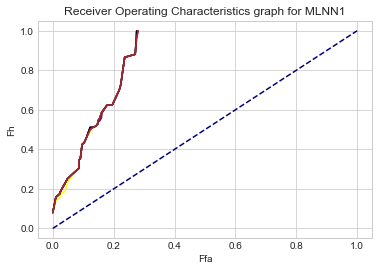

AUC: 0.135377914568168


In [19]:
#------------------------------Print ROC curve for noisy data levels (1-9)------------- 
colours = ['red','gray','orange','green','blue','yellow','black','purple','brown']
for i,j in zip(range(9),colours):
    a = sorted(ffa_noisy_list[i*32:(i+1)*32])
    b = sorted(fh_noisy_list[i*32:(i+1)*32])
    plt.plot(a,b, color = j)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver Operating Characteristics graph for MLNN1')
plt.show() 

#------------------------------Print AUC (area under the curve)-----------------------
auc = np.trapz(a,b)
print('AUC:', auc)
#------------------------------As most of the ffa and fh values are similar to each
#---------------------------------------------------------other the graphs overlapped below------------------

In [20]:
print("The ffa values for Noiseimage input:")
print (ffa_noisy_list)
print("The fh values for Noise image input:")
print (fh_list)

The ffa values for Noiseimage input:
[0.02336448598130841, 0.010101010101010102, 0.22330097087378642, 0.0, 0.15458937198067632, 0.27439024390243905, 0.21839080459770116, 0.14893617021276595, 0.13903743315508021, 0.1778846153846154, 0.08520179372197309, 0.047619047619047616, 0.12272727272727273, 0.2756756756756757, 0.13145539906103287, 0.08597285067873303, 0.14678899082568808, 0.08796296296296297, 0.16145833333333334, 0.11004784688995216, 0.04035874439461883, 0.1595744680851064, 0.2708333333333333, 0.19553072625698323, 0.09615384615384616, 0.1031390134529148, 0.23618090452261306, 0.06944444444444445, 0.1477832512315271, 0.025423728813559324, 0.0990990990990991, 0.09049773755656108, 0.02336448598130841, 0.010101010101010102, 0.22330097087378642, 0.0, 0.15458937198067632, 0.27439024390243905, 0.21839080459770116, 0.1595744680851064, 0.13903743315508021, 0.1778846153846154, 0.08520179372197309, 0.047619047619047616, 0.12272727272727273, 0.2756756756756757, 0.13145539906103287, 0.0859728506